In [ ]:
import os
import re
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/gdrive')

In [ ]:
import re
def text_cleaner(text):
    # Check if text is a string before applying lower()
    if isinstance(text, str):
        #converting to lowercase
        newString = text.lower()
        #removing links
        newString = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', newString)
        #fetching alphabetic characters
        newString = re.sub('[^a-zA-Z#@]', ' ', newString)
        return newString
    else:
        # Handle non-string values (e.g., return empty string or original value)
        return str(text)  # Or return '' if you want to ignore non-string values

In [ ]:
train_a = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/shared_task/Train_Task_A.xlsx')  # Use read_excel for .xlsx files
#train_b  = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/shared_task/Train_Task_B.xlsx')  # Use read_excel for .xlsx files
val_a = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/shared_task/Val_Task_A.xlsx')  # Use read_excel for .xlsx files
test_a = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/shared_task/Test_Task_A.xlsx')  # Use read_excel for .xlsx files

In [ ]:
train_a['Tweet'] = train_a['Tweet'].apply(text_cleaner)
#train_b['Tweet'] = train_b['Tweet'].apply(text_cleaner)
val_a['Tweet'] = val_a['Tweet'].apply(text_cleaner)
test_a['Tweet'] = test_a['Tweet'].apply(text_cleaner)
#val_b['Tweet'] = val_b['Tweet'].apply(text_cleaner)
#val_b
# Verify the sizes of the splits
print(f"Train set size: {len(train_a)}")
print(f"Validation set size: {len(val_a)}")
print(f"test set size: {len(test_a)}")



Train set size: 6396
Validation set size: 800
test set size: 800


In [ ]:
import pandas as pd

# Assume train_set is a DataFrame with columns ['Hate', 'Fake']
label_counts = train_a[['Hate', 'Fake']].apply(pd.Series.value_counts)
print(label_counts)


   Hate  Fake
1  4101  3286
0  2295  3110


In [ ]:

# Assume train_set is a DataFrame with columns ['Hate', 'Fake']
label_counts = val_a[['Hate', 'Fake']].apply(pd.Series.value_counts)
print(label_counts)

   Hate  Fake
1   513   423
0   287   377


In [ ]:
# Assume train_set is a DataFrame with columns ['Hate', 'Fake']
label_counts = test_a[['Hate', 'Fake']].apply(pd.Series.value_counts)
print(label_counts)

   Hate  Fake
1   513   417
0   287   383


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import torch
from datasets import Dataset
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Load the pre-trained tokenizer (HingRoBERTa)
model_name = 'l3cube-pune/hing-roberta'  # Replace with desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load Task A data
# Assuming data is already loaded as `train_set` and `val_set`

# Extract relevant columns
train_texts = train_a['Tweet'].tolist()
train_labels = train_a[['Hate', 'Fake']].values.tolist()  # Multi-label binary targets
test_texts = val_a['Tweet'].tolist()
test_labels = val_a[['Hate', 'Fake']].values.tolist()

# Compute class weights
class_weights = {}
for i, label_name in enumerate(['Hate', 'Fake']):
    class_weights[label_name] = compute_class_weight(
        class_weight="balanced",
        classes=np.array([0, 1]),
        y=[label[i] for label in train_labels]
    )

# Convert weights to tensor for PyTorch
hate_class_weights = torch.tensor(class_weights['Hate'], dtype=torch.float)
fake_class_weights = torch.tensor(class_weights['Fake'], dtype=torch.float)

# Custom loss with class weights
class MultiLabelTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # **kwargs added here
        labels = inputs.pop('labels')  # Extract labels
        outputs = model(**inputs)  # Forward pass
        logits = outputs.logits
        # Binary Cross-Entropy Loss with class weights
        # Move pos_weight to the same device as logits
        pos_weight = torch.tensor([hate_class_weights[1], fake_class_weights[1]]).to(logits.device)
        loss_fct = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        loss = loss_fct(logits, labels.float())
        return (loss, outputs) if return_outputs else loss
# Convert to Hugging Face Dataset
train_data = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
test_data = Dataset.from_dict({'text': test_texts, 'labels': test_labels})

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length')

train_data = train_data.map(tokenize_function, batched=True)
test_data = test_data.map(tokenize_function, batched=True)

# Load pre-trained model with custom output layer
num_labels = 2  # Two labels (Hate and Fake)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    fp16=True,
)

# Initialize Trainer with MultiLabelTrainer
trainer = MultiLabelTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
)

# Fine-tune the model
trainer.train()

# Evaluate the model
predictions = trainer.predict(test_data)
predicted_logits = predictions.predictions
predicted_probs = torch.sigmoid(torch.tensor(predicted_logits)).numpy()  # Convert logits to probabilities
predicted_labels = (predicted_probs > 0.5).astype(int)  # Threshold at 0.5

# Print classification metrics
print("Classification Report:")
for i, label_name in enumerate(['Hate', 'Fake']):
    print(f"\nMetrics for {label_name}:")
    print(classification_report(
        [label[i] for label in test_labels],
        [pred[i] for pred in predicted_labels]
    ))

# Save results for analysis
results_df = pd.DataFrame({
    "Id": val_a['Id'],
    "Tweet": val_a['Tweet'],
    "Actual_Hate": [label[0] for label in test_labels],
    "Actual_Fake": [label[1] for label in test_labels],
    "Predicted_Hate": [pred[0] for pred in predicted_labels],
    "Predicted_Fake": [pred[1] for pred in predicted_labels]
})
results_df.to_excel("/content/drive/MyDrive/Colab Notebooks/shared_task/task_a_val_predictions.xlsx", index=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Map:   0%|          | 0/6396 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/hing-roberta and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-8-454796b8a38b>:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MultiLabelTrainer.__init__`. Use `processing_class` instead.
  trainer = MultiLabelTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingA

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.450800,0.426142
2,0.337600,0.421114


Classification Report:

Metrics for Hate:
              precision    recall  f1-score   support

           0       0.70      0.73      0.72       287
           1       0.84      0.83      0.84       513

    accuracy                           0.79       800
   macro avg       0.77      0.78      0.78       800
weighted avg       0.79      0.79      0.79       800


Metrics for Fake:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       377
           1       0.84      0.78      0.81       423

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



In [ ]:
import pandas as pd
import torch
from sklearn.metrics import classification_report

test_texts1 = test_a['Tweet'].astype(str).tolist()  # Convert all elements to strings
test_labels1 = test_a[['Hate', 'Fake']].values.tolist()
data1 = Dataset.from_dict({'text': test_texts1, 'labels': test_labels1})

# Tokenize the data1 dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length')

data1 = data1.map(tokenize_function, batched=True)

# Predict on the test set
predictions = trainer.predict(data1)

# Convert logits to probabilities
predicted_logits = predictions.predictions
predicted_probs = torch.sigmoid(torch.tensor(predicted_logits)).numpy()  # Convert logits to probabilities
predicted_labels1 = (predicted_probs > 0.5).astype(int)  # Apply threshold of 0.5 to get final labels

# Prepare the results to save
# Use val_a['Tweet'] instead of val_set['Tweet'] for consistency in length
results_df = pd.DataFrame({
    "Id": test_a['Id'],  # Assuming the 'Id' column is present in val_set
    "Tweet": test_a['Tweet'], # Use val_a['Tweet'] for consistency
    "Actual_Hate": [label[0] for label in test_labels1],
    "Actual_Fake": [label[1] for label in test_labels1],
    "Predicted_Hate": [pred[0] for pred in predicted_labels1],
    "Predicted_Fake": [pred[1] for pred in predicted_labels1]
})

# Save results to a CSV file
results_df.to_csv("/content/drive/MyDrive/Colab Notebooks/task_a_test_predictions.csv", index=False)

# Print some of the results for verification
print(results_df.head())

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

     Id                                              Tweet  Actual_Hate  \
0  1516       crore hindu  others  ghar me band h  leki...            1   
1  3359  jo bhosadiwale shaheen bagh khali nahi kara pa...            1   
2  6706      ak bar itihas par lena bhavi jaan                        0   
3  6472                     le hindu    ye kab hua                    0   
4  4174  #supremecourt hamare sath aisa kab tak hota ra...            0   

   Actual_Fake  Predicted_Hate  Predicted_Fake  
0            1               1               1  
1            0               1               0  
2            0               0               0  
3            0               0               0  
4            1               0               0  


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report for Hate predictions
print("Classification Report for Hate Predictions:")
print(classification_report(results_df['Actual_Hate'], results_df['Predicted_Hate'], target_names=["Not Hate", "Hate"]))

# Generate classification report for Fake predictions
print("Classification Report for Fake Predictions:")
print(classification_report(results_df['Actual_Fake'], results_df['Predicted_Fake'], target_names=["Real", "Fake"]))

Classification Report for Hate Predictions:
              precision    recall  f1-score   support

    Not Hate       0.71      0.73      0.72       287
        Hate       0.85      0.83      0.84       513

    accuracy                           0.79       800
   macro avg       0.78      0.78      0.78       800
weighted avg       0.80      0.79      0.79       800

Classification Report for Fake Predictions:
              precision    recall  f1-score   support

        Real       0.79      0.83      0.81       383
        Fake       0.83      0.80      0.81       417

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



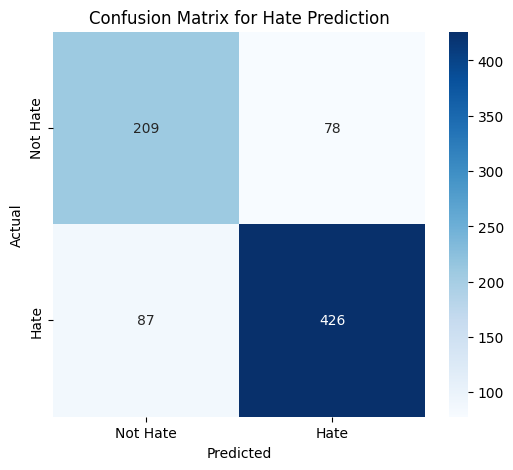

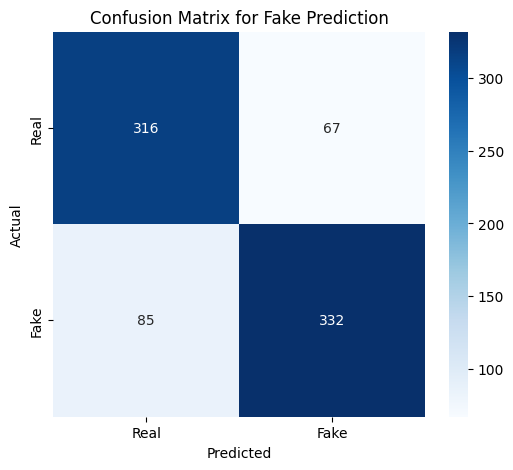

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate confusion matrix for Hate predictions
hate_cm = confusion_matrix(results_df['Actual_Hate'], results_df['Predicted_Hate'])
fake_cm = confusion_matrix(results_df['Actual_Fake'], results_df['Predicted_Fake'])

# Function to plot confusion matrix
def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

# Plot Hate confusion matrix
plot_confusion_matrix(hate_cm, labels=["Not Hate", "Hate"], title="Confusion Matrix for Hate Prediction")

# Plot Fake confusion matrix
plot_confusion_matrix(fake_cm, labels=["Real", "Fake"], title="Confusion Matrix for Fake Prediction")


Getting prediction Task_B test set

In [ ]:
import pandas as pd

# Assuming the following are available:
# `val_set`: Original test dataset with 'Id' and 'Tweet'.
# `test_labels`: Actual labels as a list of [Hate, Fake].
# `predicted_labels`: Predicted labels as a list of [Hate, Fake].

# Convert predictions and actual labels to DataFrames
results_df = pd.DataFrame({
    "Id": val_a['Id'],
    "Tweet": val_a['Tweet'],
    "Actual_Hate": [label[0] for label in test_labels],
    "Actual_Fake": [label[1] for label in test_labels],
    "Predicted_Hate": [pred[0] for pred in predicted_labels],
    "Predicted_Fake": [pred[1] for pred in predicted_labels]
})

# Identify misclassified examples
misclassified_df = results_df[
    (results_df["Actual_Hate"] != results_df["Predicted_Hate"]) |
    (results_df["Actual_Fake"] != results_df["Predicted_Fake"])
]

# Save misclassified examples to a CSV
output_path = "/content/drive/MyDrive/Colab Notebooks/shared_task/val_misclassified_task_a.csv"
misclassified_df.to_csv(output_path, index=False)

print(f"Misclassified examples saved to: {output_path}")


Misclassified examples saved to: /content/drive/MyDrive/Colab Notebooks/misclassified_task_a.csv
